# Distilbert

## inizializzazione

In [ ]:
!pip install accelerate -U > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install --upgrade transformers datasets accelerate > /dev/null 2>&1
!pip install torch > /dev/null 2>&1

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)

### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Arguments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 16

# optim
learning_rate = 1e-4
weight_decay = 0.01 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the seed for reproducibility
set_seed(42)

In [ ]:
from datasets import load_dataset

print("Loading the dataset ...")
ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

## Let's see an example...
print(f"Premise: {ds['train']['premise'][12]}")
print(f"Hypothesis: {ds['train']['hypothesis'][12]}")
print(f"Label: {'Entailment' if ds['train']['label'][12] == 1 else 'Non-entailment'}")

## The structure of the huggingface dataset.
## Here the test set cannot be used since is a blind test set, so there aren't the gold labels.
ds

# Dividi il dataset nelle rispettive variabili
train_dataset = ds['train']
validation_dataset = ds['validation']
test_dataset = ds['test']

# Opzionalmente, puoi stampare alcune informazioni sui dataset
print(f"Train dataset: {train_dataset.num_rows} samples")
print(f"Validation dataset: {validation_dataset.num_rows} samples")
print(f"Test dataset: {test_dataset.num_rows} samples")

Loading the dataset ...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/337 [00:00<?, ? examples/s]

Premise: Whoopi Goldberg . From 1998 to 2002 , she was co-producer of the television game show Hollywood Squares .
Hypothesis: Whoopi Goldberg co-produced an American dance tournament.
Label: Non-entailment
Train dataset: 51086 samples
Validation dataset: 2288 samples
Test dataset: 2287 samples


## Metriche

In [ ]:
!pip install evaluate > /dev/null 2>&1

In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Carica le metriche con la nuova libreria
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
load_precision = evaluate.load("precision")
load_recall = evaluate.load("recall", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

## Distilbert-base-uncased

Dataset Complete

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_val = validation_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test = tokenized_datasets_test.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['premise', 'hypothesis'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing the dataset ...


Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=epochs,                      # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                             # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                            # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                               # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.458700,0.813900,0.691871,0.678574,0.695357,0.691871
2000,0.455800,0.755993,0.718094,0.704420,0.716466,0.718094
3000,0.437400,0.723843,0.728147,0.721617,0.734296,0.728147
4000,0.373600,0.854788,0.718094,0.700986,0.725375,0.718094
5000,0.360800,0.761449,0.740385,0.730578,0.740645,0.740385
6000,0.352900,0.763534,0.738636,0.725803,0.738848,0.738636
7000,0.315200,0.871170,0.745192,0.736433,0.745949,0.745192
8000,0.289600,0.859836,0.741259,0.732833,0.745384,0.741259
9000,0.290700,0.852200,0.740385,0.733793,0.742083,0.740385
10000,0.265200,0.933711,0.741259,0.732598,0.744766,0.741259


TrainOutput(global_step=15965, training_loss=0.3089137124223766, metrics={'train_runtime': 12078.7365, 'train_samples_per_second': 21.147, 'train_steps_per_second': 1.322, 'total_flos': 3.3342054637396284e+16, 'train_loss': 0.3089137124223766, 'epoch': 5.0})

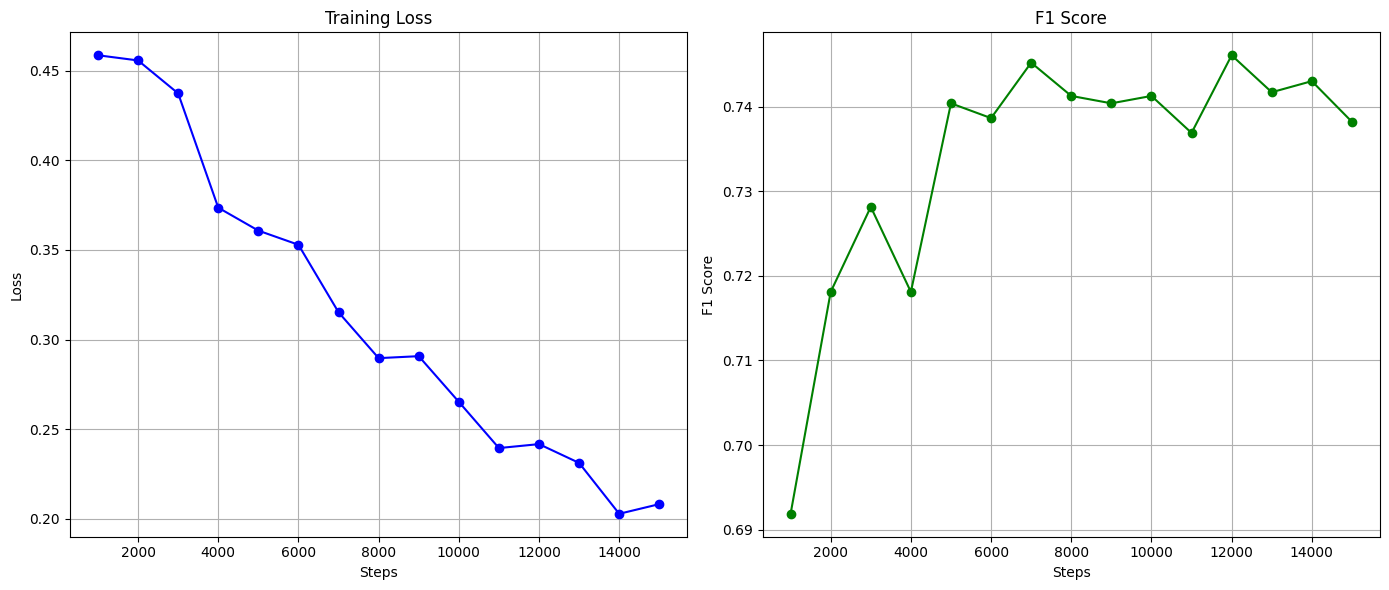

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
loss = [0.458700, 0.455800, 0.437400, 0.373600, 0.360800, 0.352900, 0.315200, 0.289600, 0.290700, 0.265200, 0.239400, 0.241600, 0.231100, 0.202700, 0.208100]
# Lista della F1 score
f1_scores = [
    0.678574,  # Step 1000
    0.704420,  # Step 2000
    0.721617,  # Step 3000
    0.700986,  # Step 4000
    0.730578,  # Step 5000
    0.725803,  # Step 6000
    0.736433,  # Step 7000
    0.732833,  # Step 8000
    0.733793,  # Step 9000
    0.732598,  # Step 10000
    0.726471,  # Step 11000
    0.738064,  # Step 12000
    0.733607,  # Step 13000
    0.733776,  # Step 14000
    0.730611   # Step 15000
]

# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafico della loss
ax1.plot(steps, loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della F1 score
ax2.plot(steps, f1_score, marker='o', color='green')
ax2.set_title('F1 Score')
ax2.set_xlabel('Steps')
ax2.set_ylabel('F1 Score')
ax2.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.0885932445526123,
 'eval_model_preparation_time': 0.01,
 'eval_accuracy': 0.7184083952776563,
 'eval_f1': 0.7085411866396955,
 'eval_precision': 0.7156194071443023,
 'eval_recall': 0.7184083952776563,
 'eval_runtime': 22.9625,
 'eval_samples_per_second': 99.597,
 'eval_steps_per_second': 12.455}

In [ ]:
from prettytable import PrettyTable

# Dati da visualizzare
metrics = {
    'eval_loss': 1.0885932445526123,
    'eval_accuracy': 0.7184083952776563,
    'eval_f1': 0.7085411866396955,
    'eval_precision': 0.7156194071443023,
    'eval_recall': 0.7184083952776563,
    'eval_runtime': 22.9625,
    'eval_samples_per_second': 99.597,
    'epoch': 5.0
}

# Crea una tabella
table = PrettyTable()
table.field_names = ["Metric", "Value"]
for key, value in metrics.items():
    table.add_row([key, f"{value:.4f}"])

print(table)

+-------------------------+---------+
|          Metric         |  Value  |
+-------------------------+---------+
|        eval_loss        |  1.0886 |
|      eval_accuracy      |  0.7184 |
|         eval_f1         |  0.7085 |
|      eval_precision     |  0.7156 |
|       eval_recall       |  0.7184 |
|       eval_runtime      | 22.9625 |
| eval_samples_per_second | 99.5970 |
|          epoch          |  5.0000 |
+-------------------------+---------+


## Distilbert-base-uncased

Dataset adversarial

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

test_dataset_ad = ds_ad['test']

# Opzionalmente, puoi stampare alcune informazioni sui dataset
print(f"Test dataset: {test_dataset_ad.num_rows} samples")

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test dataset: 337 samples
Tokenizing the dataset ...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 2.0038979053497314,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.5192878338278932,
 'eval_f1': 0.5226190553135146,
 'eval_precision': 0.5477153045714357,
 'eval_recall': 0.5192878338278932,
 'eval_runtime': 2.9286,
 'eval_samples_per_second': 115.072,
 'eval_steps_per_second': 14.683}

In [ ]:
from prettytable import PrettyTable

# Dati da visualizzare
metrics = {
    'eval_loss': 2.0038979053497314,
    'eval_model_preparation_time': 0.0029,
    'eval_accuracy': 0.5192878338278932,
    'eval_f1': 0.5226190553135146,
    'eval_precision': 0.5477153045714357,
    'eval_recall': 0.5192878338278932,
    'eval_runtime': 2.9286,
    'eval_samples_per_second': 115.072,
    'eval_steps_per_second': 14.683,
    'epoch': 5.0
}

# Crea una tabella
table = PrettyTable()
table.field_names = ["Metric", "Value"]
for key, value in metrics.items():
    table.add_row([key, f"{value:.4f}"])

print(table)

+-----------------------------+----------+
|            Metric           |  Value   |
+-----------------------------+----------+
|          eval_loss          |  2.0039  |
| eval_model_preparation_time |  0.0029  |
|        eval_accuracy        |  0.5193  |
|           eval_f1           |  0.5226  |
|        eval_precision       |  0.5477  |
|         eval_recall         |  0.5193  |
|         eval_runtime        |  2.9286  |
|   eval_samples_per_second   | 115.0720 |
|    eval_steps_per_second    | 14.6830  |
|            epoch            |  5.0000  |
+-----------------------------+----------+


# Roberta

## Inizializzazione

In [ ]:
!pip install accelerate -U > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install --upgrade transformers datasets accelerate > /dev/null 2>&1

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)

### Model Parameters
# we will use with Distil-BERT
language_model_name = "roberta-base"

### Training Arguments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 16

# optim
learning_rate = 1e-5
weight_decay = 1e-4 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the seed for reproducibility
set_seed(42)

In [ ]:
from datasets import load_dataset

print("Loading the dataset ...")
ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

## Let's see an example...
print(f"Premise: {ds['train']['premise'][12]}")
print(f"Hypothesis: {ds['train']['hypothesis'][12]}")
print(f"Label: {'Entailment' if ds['train']['label'][12] == 1 else 'Non-entailment'}")

## The structure of the huggingface dataset.
## Here the test set cannot be used since is a blind test set, so there aren't the gold labels.
ds

# Dividi il dataset nelle rispettive variabili
train_dataset = ds['train']
validation_dataset = ds['validation']
test_dataset = ds['test']

# Opzionalmente, puoi stampare alcune informazioni sui dataset
print(f"Train dataset: {train_dataset.num_rows} samples")
print(f"Validation dataset: {validation_dataset.num_rows} samples")
print(f"Test dataset: {test_dataset.num_rows} samples")

Loading the dataset ...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/337 [00:00<?, ? examples/s]

Premise: Whoopi Goldberg . From 1998 to 2002 , she was co-producer of the television game show Hollywood Squares .
Hypothesis: Whoopi Goldberg co-produced an American dance tournament.
Label: Non-entailment
Train dataset: 51086 samples
Validation dataset: 2288 samples
Test dataset: 2287 samples


## metriche

In [ ]:
!pip install evaluate > /dev/null 2>&1

In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Carica le metriche con la nuova libreria
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
load_precision = evaluate.load("precision")
load_recall = evaluate.load("recall", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

## Primo dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_val = validation_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test = tokenized_datasets_test.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['premise', 'hypothesis'])

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing the dataset ...


Map:   0%|          | 0/51086 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/51086 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                            # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                           # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                              # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.773600,0.785203,0.716346,0.696151,0.717505,0.716346
2000,0.429700,0.689911,0.749126,0.742138,0.743672,0.749126
3000,0.400600,0.666815,0.764860,0.760480,0.768027,0.764860
4000,0.347000,0.851126,0.749563,0.735900,0.752889,0.749563
5000,0.340400,0.708634,0.763112,0.753426,0.761676,0.763112
6000,0.323000,0.730600,0.757867,0.745822,0.758122,0.757867
7000,0.292200,0.809005,0.764423,0.755228,0.762193,0.764423
8000,0.276400,0.771194,0.762675,0.755091,0.761482,0.762675
9000,0.269400,0.825022,0.760490,0.753640,0.758682,0.760490


TrainOutput(global_step=9579, training_loss=0.3764916545526632, metrics={'train_runtime': 13937.3788, 'train_samples_per_second': 10.996, 'train_steps_per_second': 0.687, 'total_flos': 4.007870202165178e+16, 'train_loss': 0.3764916545526632, 'epoch': 3.0})

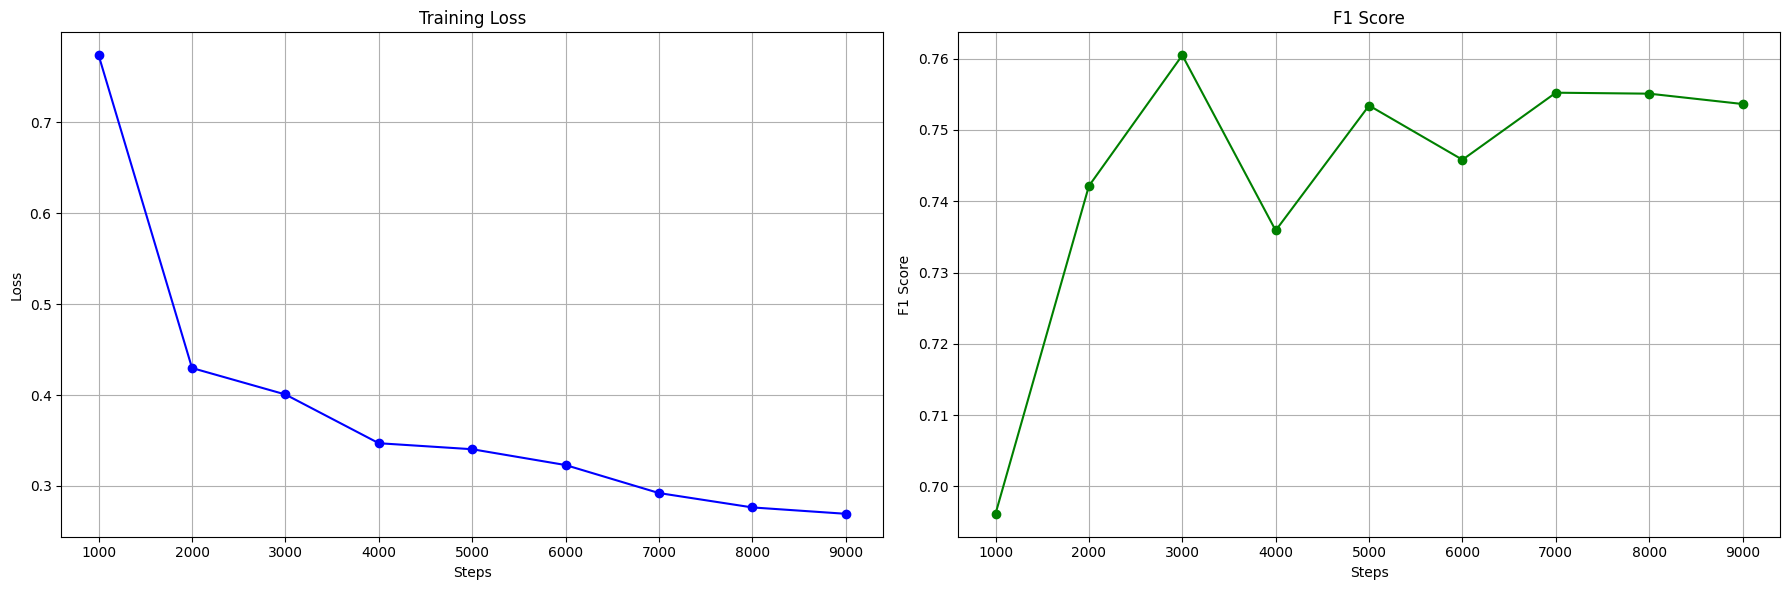

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
training_loss = [0.773600, 0.429700, 0.400600, 0.347000, 0.340400, 0.323000, 0.292200, 0.276400, 0.269400]
f1_scores = [0.696151, 0.742138, 0.760480, 0.735900, 0.753426, 0.745822, 0.755228, 0.755091, 0.753640]

# Creazione dei grafici
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 6))

# Grafico della training loss
ax1.plot(steps, training_loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della F1 score
ax3.plot(steps, f1_scores, marker='o', color='green')
ax3.set_title('F1 Score')
ax3.set_xlabel('Steps')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()


In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.0314030647277832,
 'eval_model_preparation_time': 0.0041,
 'eval_accuracy': 0.7538259728902492,
 'eval_f1': 0.7479119634982815,
 'eval_precision': 0.7499334344708114,
 'eval_recall': 0.7538259728902492,
 'eval_runtime': 51.0898,
 'eval_samples_per_second': 44.764,
 'eval_steps_per_second': 5.598}

In [ ]:
from prettytable import PrettyTable

# Dati da visualizzare
metrics = {
    'eval_loss': 1.0314030647277832,
    'eval_model_preparation_time': 0.0041,
    'eval_accuracy': 0.7538259728902492,
    'eval_f1': 0.7479119634982815,
    'eval_precision': 0.7499334344708114,
    'eval_recall': 0.7538259728902492,
    'eval_runtime': 51.0898,
    'eval_samples_per_second': 44.764,
    'eval_steps_per_second': 5.598,
    'epoch': 3.0
}

# Crea una tabella
table = PrettyTable()
table.field_names = ["Metric", "Value"]
for key, value in metrics.items():
    table.add_row([key, f"{value:.4f}"])

print(table)

+-----------------------------+---------+
|            Metric           |  Value  |
+-----------------------------+---------+
|          eval_loss          |  1.0314 |
| eval_model_preparation_time |  0.0041 |
|        eval_accuracy        |  0.7538 |
|           eval_f1           |  0.7479 |
|        eval_precision       |  0.7499 |
|         eval_recall         |  0.7538 |
|         eval_runtime        | 51.0898 |
|   eval_samples_per_second   | 44.7640 |
|    eval_steps_per_second    |  5.5980 |
|            epoch            |  5.0000 |
+-----------------------------+---------+


## Adversarial

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

test_dataset_ad = ds_ad['test']

# Opzionalmente, puoi stampare alcune informazioni sui dataset
print(f"Test dataset: {test_dataset_ad.num_rows} samples")

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

Test dataset: 337 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing the dataset ...


Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                            # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                           # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                              # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.748800,1.306400,0.548961,0.549095,0.554475,0.548961
2000,0.426200,1.182194,0.575668,0.576191,0.586734,0.575668
3000,0.399500,1.092905,0.584570,0.580578,0.584114,0.584570
4000,0.346000,1.365942,0.540059,0.541183,0.567771,0.540059
5000,0.336000,1.113876,0.599407,0.599360,0.600246,0.599407
6000,0.321300,1.232618,0.581602,0.583546,0.589764,0.581602
7000,0.291900,1.412273,0.584570,0.586032,0.590546,0.584570
8000,0.276100,1.382645,0.590504,0.590743,0.591179,0.590504
9000,0.269400,1.445450,0.593472,0.593702,0.594065,0.593472


TrainOutput(global_step=9579, training_loss=0.3725056889684629, metrics={'train_runtime': 14355.4416, 'train_samples_per_second': 10.676, 'train_steps_per_second': 0.667, 'total_flos': 4.007870202165178e+16, 'train_loss': 0.3725056889684629, 'epoch': 3.0})

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.430176854133606,
 'eval_accuracy': 0.5816023738872403,
 'eval_f1': 0.5824112480735443,
 'eval_precision': 0.5835370162743497,
 'eval_recall': 0.5816023738872403,
 'eval_runtime': 7.3243,
 'eval_samples_per_second': 46.011,
 'eval_steps_per_second': 5.871,
 'epoch': 3.0}

In [ ]:
from prettytable import PrettyTable

# Dati da visualizzare
metrics = {
    'eval_loss': 1.430176854133606,
    'eval_accuracy': 0.5816023738872403,
    'eval_f1': 0.5824112480735443,
    'eval_precision': 0.5835370162743497,
    'eval_recall': 0.5816023738872403,
    'eval_runtime': 7.3243,
    'eval_samples_per_second': 46.011,
    'eval_steps_per_second': 5.871,
    'epoch': 3.0
}

# Crea una tabella
table = PrettyTable()
table.field_names = ["Metric", "Value"]
for key, value in metrics.items():
    table.add_row([key, f"{value:.4f}"])

print(table)

+-------------------------+---------+
|          Metric         |  Value  |
+-------------------------+---------+
|        eval_loss        |  1.4302 |
|      eval_accuracy      |  0.5816 |
|         eval_f1         |  0.5824 |
|      eval_precision     |  0.5835 |
|       eval_recall       |  0.5816 |
|       eval_runtime      |  7.3243 |
| eval_samples_per_second | 46.0110 |
|  eval_steps_per_second  |  5.8710 |
|          epoch          |  3.0000 |
+-------------------------+---------+


# Train Augmented Dataset

## inizializzazione

In [ ]:
!pip install accelerate -U > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install --upgrade transformers datasets accelerate > /dev/null 2>&1
!pip install torch > /dev/null 2>&1

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)

### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Arguments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 16

# optim
learning_rate = 1e-4
weight_decay = 0.01 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the seed for reproducibility
set_seed(42)

In [ ]:
from datasets import load_dataset

# Carica il dataset da Hugging Face
print("Loading the dataset ...")
ds = load_dataset("Masergio/modified_dataset_train")

# Stampa un esempio
print(f"Premise: {ds['train']['premise'][0]}")

# Suddivisione del dataset in 90% train e 10% validation
train_valid_split = ds['train'].train_test_split(test_size=0.1)

# Assegna le variabili per il train e il validation set
train_dataset = train_valid_split['train']
validation_dataset = train_valid_split['test']

# Opzionalmente, stampa il numero di campioni in ciascun set
print(f"Train dataset: {train_dataset.num_rows} samples")
print(f"Validation dataset: {validation_dataset.num_rows} samples")

Loading the dataset ...
Premise: Sophie Turner ( born 21 February 1996 ) is an English actress . Sophie Turner ( born 30 April 1984 ) is an Australian model , reality television personality and lawyer who first came to prominence as a contestant on the Australian television series Search for a Supermodel .
Train dataset: 23357 samples
Validation dataset: 2596 samples


In [ ]:
print("Loading the dataset ...")
ds_1 = load_dataset("tommasobonomo/sem_augmented_fever_nli")

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

# Dividi il dataset nelle rispettive variabili
test_dataset_1 = ds_1['test']
test_dataset_ad = ds_ad['test']

Loading the dataset ...


## Metriche

In [ ]:
!pip install evaluate > /dev/null 2>&1

In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Carica le metriche con la nuova libreria
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
load_precision = evaluate.load("precision")
load_recall = evaluate.load("recall", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

## First Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_val = validation_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test_1 = test_dataset_1.map(tokenize_function, batched=True)
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test_1 = tokenized_datasets_test_1.map(convert_labels_to_int)
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_1 = tokenized_datasets_test_1.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing the dataset ...


Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                             # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                            # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                               # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.978200,0.818263,0.616333,0.560737,0.514395,0.616333
2000,0.723100,0.706788,0.711864,0.704554,0.709545,0.711864
3000,0.626600,0.680324,0.738059,0.731635,0.737840,0.738059
4000,0.521100,0.657200,0.751541,0.746586,0.748202,0.751541


TrainOutput(global_step=4380, training_loss=0.6941303514454463, metrics={'train_runtime': 3234.8021, 'train_samples_per_second': 21.662, 'train_steps_per_second': 1.354, 'total_flos': 9095391903007980.0, 'train_loss': 0.6941303514454463, 'epoch': 3.0})

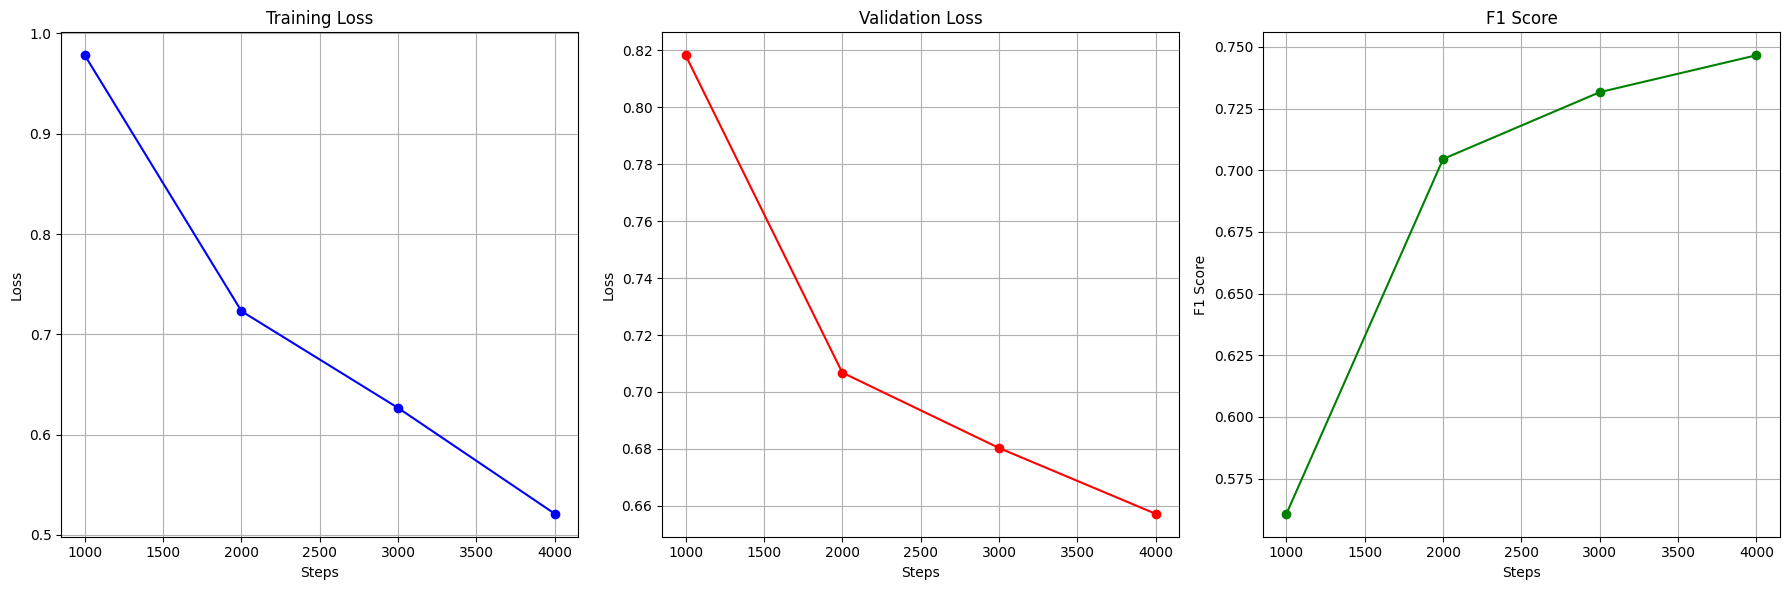

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [1000, 2000, 3000, 4000]
training_loss = [0.978200, 0.723100, 0.626600, 0.521100]
validation_loss = [0.818263, 0.706788, 0.680324, 0.657200]
f1_scores = [0.560737, 0.704554, 0.731635, 0.746586]

# Creazione dei grafici
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Grafico della training loss
ax1.plot(steps, training_loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della validation loss
ax2.plot(steps, validation_loss, marker='o', color='red')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss')
ax2.grid(True)

# Grafico della F1 score
ax3.plot(steps, f1_scores, marker='o', color='green')
ax3.set_title('F1 Score')
ax3.set_xlabel('Steps')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_1,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.9918287992477417,
 'eval_model_preparation_time': 0.0023,
 'eval_accuracy': 0.6432006996064713,
 'eval_f1': 0.6285209312928715,
 'eval_precision': 0.6431446738242709,
 'eval_recall': 0.6432006996064713,
 'eval_runtime': 21.8936,
 'eval_samples_per_second': 104.46,
 'eval_steps_per_second': 13.063}

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.3636679649353027,
 'eval_model_preparation_time': 0.0041,
 'eval_accuracy': 0.4836795252225519,
 'eval_f1': 0.47974622417272256,
 'eval_precision': 0.5294630806895014,
 'eval_recall': 0.4836795252225519,
 'eval_runtime': 2.7983,
 'eval_samples_per_second': 120.43,
 'eval_steps_per_second': 15.366}

## Second Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

language_model_name = "roberta-base"

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_val = validation_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test_1 = test_dataset_1.map(tokenize_function, batched=True)
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test_1 = tokenized_datasets_test_1.map(convert_labels_to_int)
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_1 = tokenized_datasets_test_1.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing the dataset ...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/23357 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/23357 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=500,                             # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=500,                            # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=500,                               # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.021600,0.844153,0.625193,0.566941,0.521795,0.625193
1000,0.767400,0.666352,0.726502,0.724664,0.723319,0.726502
1500,0.677300,0.651667,0.738444,0.744849,0.756906,0.738444
2000,0.588500,0.599036,0.770031,0.765431,0.768492,0.770031
2500,0.579400,0.567112,0.782357,0.776031,0.783283,0.782357
3000,0.539400,0.576820,0.787750,0.782981,0.787751,0.787750
3500,0.476400,0.558470,0.793914,0.792290,0.791390,0.793914
4000,0.463500,0.564994,0.798921,0.794059,0.796195,0.798921


TrainOutput(global_step=4380, training_loss=0.622271320917835, metrics={'train_runtime': 6665.4411, 'train_samples_per_second': 10.513, 'train_steps_per_second': 0.657, 'total_flos': 1.8242573634150896e+16, 'train_loss': 0.622271320917835, 'epoch': 3.0})

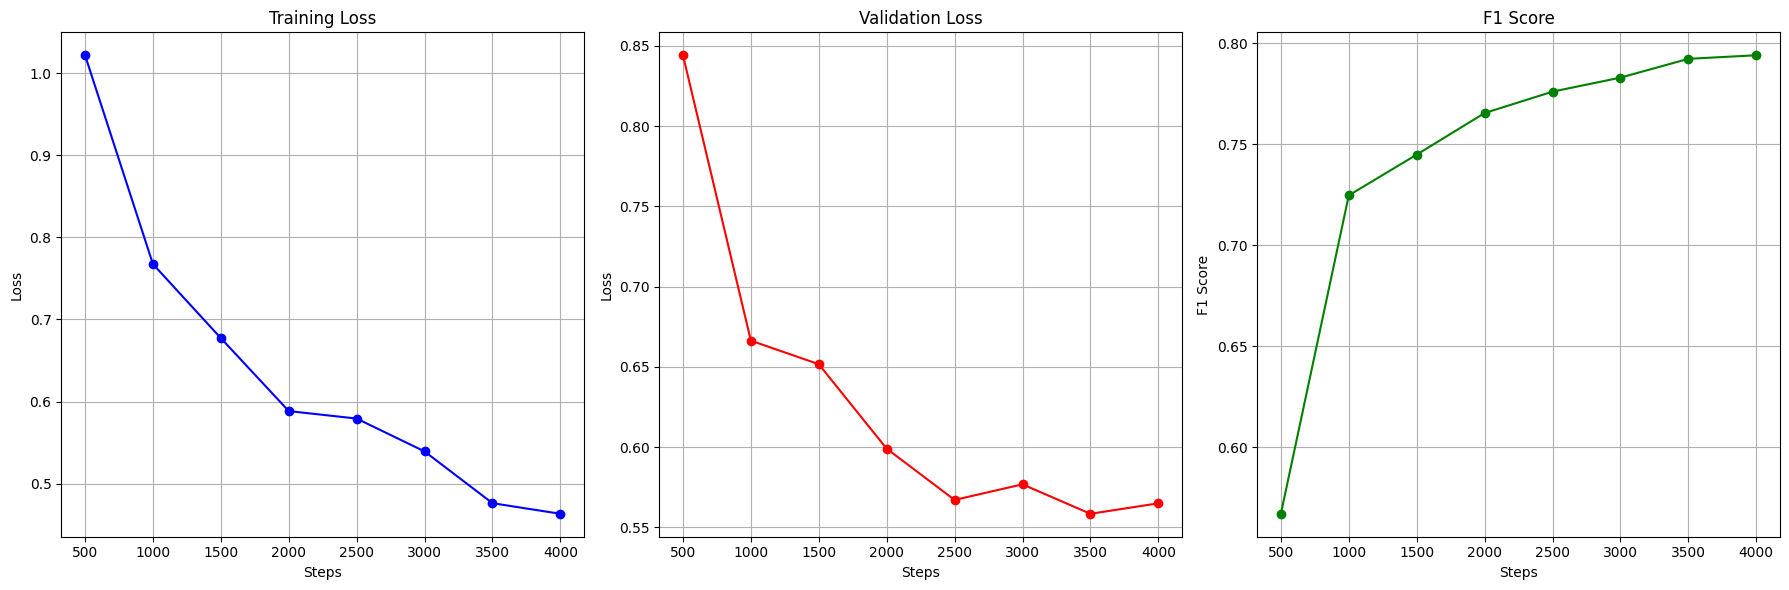

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
training_loss = [1.021600, 0.767400, 0.677300, 0.588500, 0.579400, 0.539400, 0.476400, 0.463500]
validation_loss = [0.844153, 0.666352, 0.651667, 0.599036, 0.567112, 0.576820, 0.558470, 0.564994]
f1_scores = [0.566941, 0.724664, 0.744849, 0.765431, 0.776031, 0.782981, 0.792290, 0.794059]

# Creazione dei grafici
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Grafico della training loss
ax1.plot(steps, training_loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della validation loss
ax2.plot(steps, validation_loss, marker='o', color='red')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss')
ax2.grid(True)

# Grafico della F1 score
ax3.plot(steps, f1_scores, marker='o', color='green')
ax3.set_title('F1 Score')
ax3.set_xlabel('Steps')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_1,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.8463522791862488,
 'eval_model_preparation_time': 0.0064,
 'eval_accuracy': 0.7017927415828596,
 'eval_f1': 0.6843586193015893,
 'eval_precision': 0.6986792313605986,
 'eval_recall': 0.7017927415828596,
 'eval_runtime': 49.2795,
 'eval_samples_per_second': 46.409,
 'eval_steps_per_second': 5.804}

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.1102951765060425,
 'eval_model_preparation_time': 0.0041,
 'eval_accuracy': 0.5578635014836796,
 'eval_f1': 0.5565504331082967,
 'eval_precision': 0.5841575997362347,
 'eval_recall': 0.5578635014836796,
 'eval_runtime': 6.9711,
 'eval_samples_per_second': 48.343,
 'eval_steps_per_second': 6.168}

# Train Complete Dataset

## inizializzazione

In [ ]:
!pip install accelerate -U > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install --upgrade transformers datasets accelerate > /dev/null 2>&1
!pip install torch > /dev/null 2>&1

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)

### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Arguments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 16

# optim
learning_rate = 1e-4
weight_decay = 0.01 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the seed for reproducibility
set_seed(42)

In [ ]:
from datasets import load_dataset

print("Loading the dataset ...")
ds_1 = load_dataset("tommasobonomo/sem_augmented_fever_nli")

ds_ad = load_dataset("iperbole/adversarial_fever_nli")

ds_aug = load_dataset("Masergio/modified_dataset_train")

# Dividi il dataset nelle rispettive variabili
test_dataset_1 = ds_1['test']
test_dataset_ad = ds_ad['test']

Loading the dataset ...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# import pandas as pd
# from tqdm import tqdm
# from datasets import DatasetDict, Dataset

# # Converti i dataset in DataFrame con una barra di progresso
# tqdm.pandas(desc="Converting to DataFrame")
# df1 = ds_1['train'].to_pandas()
# df2 = ds_aug['train'].to_pandas()

# # Unisci i DataFrame con una barra di progresso
# tqdm.pandas(desc="Concatenating DataFrames")
# combined_df = pd.concat([df1, df2], ignore_index=True)

# # Converti di nuovo in Dataset
# combined_train = Dataset.from_pandas(combined_df)

# # Creare un nuovo DatasetDict con i dati uniti
# combined_dataset = DatasetDict({
#     'train': combined_train,
#     'validation': ds_1['validation'],
#     'test': ds_1['test']
# })

# print(combined_dataset)

In [ ]:
from datasets import load_dataset

Complete_dataset = load_dataset("Masergio/complete_dataset")

## Metriche

In [ ]:
!pip install evaluate > /dev/null 2>&1

In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Carica le metriche con la nuova libreria
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
load_precision = evaluate.load("precision")
load_recall = evaluate.load("recall", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

## First Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

Complete_dataset_train = Complete_dataset["train"]
Complete_dataset_val = Complete_dataset["validation"]
Complete_dataset_test= Complete_dataset["test"]
test_dataset_ad = ds_ad["test"]

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = Complete_dataset_train.map(tokenize_function, batched=True)
tokenized_datasets_val = Complete_dataset_val.map(tokenize_function, batched=True)
tokenized_datasets_test_1 = Complete_dataset_test.map(tokenize_function, batched=True)
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test_1 = tokenized_datasets_test_1.map(convert_labels_to_int)
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_1 = tokenized_datasets_test_1.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing the dataset ...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/77039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/77039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                             # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                            # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                               # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.831400,0.940314,0.626311,0.583332,0.632306,0.626311
2000,0.593500,0.778598,0.696241,0.687762,0.700003,0.696241
3000,0.550200,0.789199,0.704545,0.691104,0.708373,0.704545
4000,0.505400,0.781304,0.718969,0.709703,0.720626,0.718969
5000,0.477100,0.762503,0.726399,0.721149,0.724415,0.726399
6000,0.416700,0.858838,0.721154,0.712199,0.731355,0.721154
7000,0.407200,0.785127,0.727710,0.717439,0.728958,0.727710
8000,0.403400,0.802230,0.721154,0.706981,0.724417,0.721154
9000,0.387400,0.788691,0.733829,0.725094,0.734319,0.733829
10000,0.364800,0.844898,0.729895,0.724453,0.732440,0.729895


TrainOutput(global_step=14445, training_loss=0.43936807718933885, metrics={'train_runtime': 10711.2785, 'train_samples_per_second': 21.577, 'train_steps_per_second': 1.349, 'total_flos': 3.0161550887850784e+16, 'train_loss': 0.43936807718933885, 'epoch': 3.0})

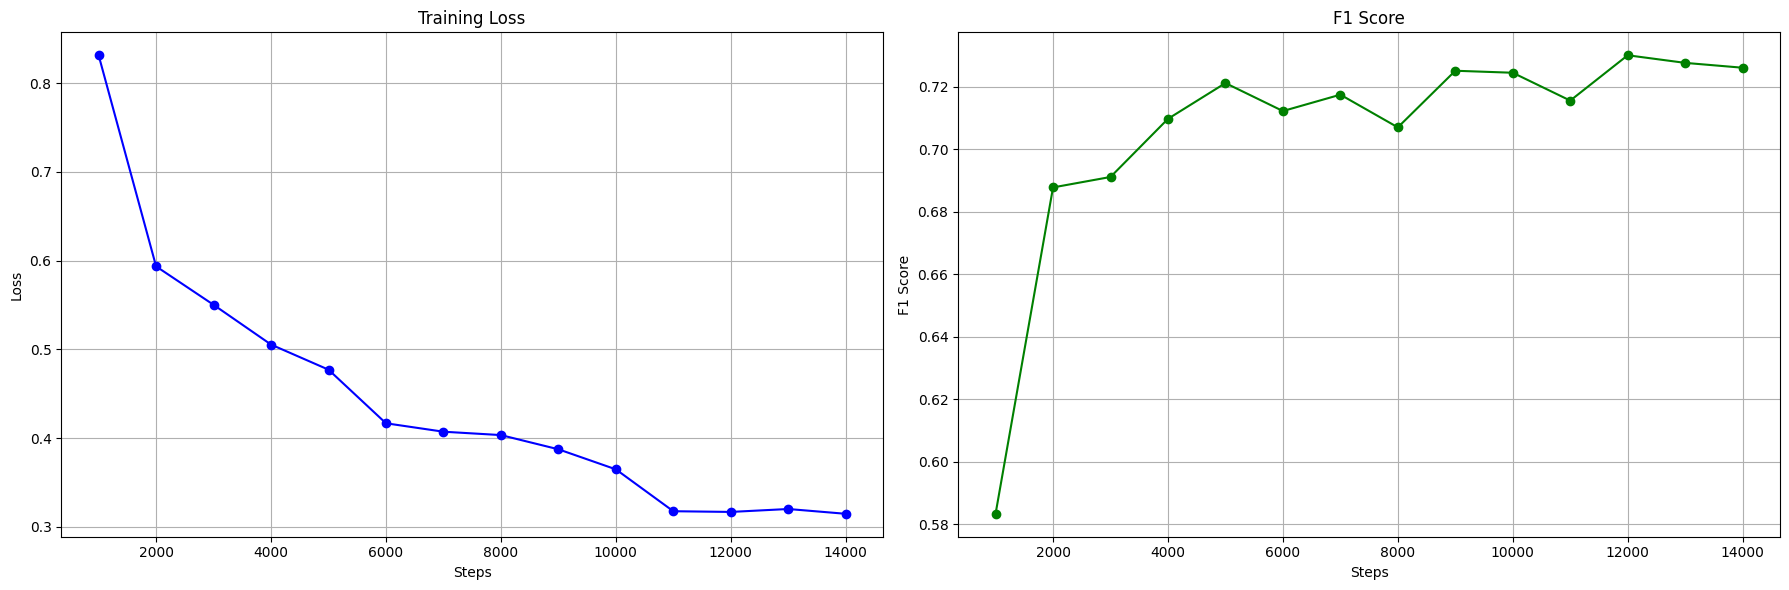

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000]
training_loss = [0.831400, 0.593500, 0.550200, 0.505400, 0.477100, 0.416700, 0.407200, 0.403400, 0.387400, 0.364800, 0.317600, 0.316800, 0.320100, 0.314700]
f1_scores = [0.583332, 0.687762, 0.691104, 0.709703, 0.721149, 0.712199, 0.717439, 0.706981, 0.725094, 0.724453, 0.715542, 0.730050, 0.727612, 0.726059]

# Creazione dei grafici
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 6))

# Grafico della training loss
ax1.plot(steps, training_loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della F1 score
ax3.plot(steps, f1_scores, marker='o', color='green')
ax3.set_title('F1 Score')
ax3.set_xlabel('Steps')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_1,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.9388504028320312,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.7031045037166593,
 'eval_f1': 0.6941106518191954,
 'eval_precision': 0.698605050775747,
 'eval_recall': 0.7031045037166593,
 'eval_runtime': 21.6276,
 'eval_samples_per_second': 105.744,
 'eval_steps_per_second': 13.224}

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.4918866157531738,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.5459940652818991,
 'eval_f1': 0.5476549795708818,
 'eval_precision': 0.5756938582725889,
 'eval_recall': 0.5459940652818991,
 'eval_runtime': 2.7456,
 'eval_samples_per_second': 122.742,
 'eval_steps_per_second': 15.661}

## Second Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

Complete_dataset_train = Complete_dataset["train"]
Complete_dataset_val = Complete_dataset["validation"]
Complete_dataset_test= Complete_dataset["test"]
test_dataset_ad = ds_ad["test"]

language_model_name = "roberta-base"

# Inizializza il modello
model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name,
    num_labels = 3  # numero di classi (es: entailment vs. non-entailment)
)

# Inizializza il tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Crea un data collator per gestire il padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Funzione di preprocessamento e tokenizzazione
def tokenize_function(examples):
  return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

  # Definisci una funzione per convertire le etichette in interi
def convert_labels_to_int(examples):
    if examples["label"] == "ENTAILMENT":
        examples["label"] = 0
    elif examples["label"] == "CONTRADICTION":
        examples["label"] = 1
    elif examples["label"] == "NEUTRAL":
        examples["label"] = 2
    return examples

# Tokenizza e preprocessa il dataset
print("Tokenizing the dataset ...")
tokenized_datasets_train = Complete_dataset_train.map(tokenize_function, batched=True)
tokenized_datasets_val = Complete_dataset_val.map(tokenize_function, batched=True)
tokenized_datasets_test_1 = Complete_dataset_test.map(tokenize_function, batched=True)
tokenized_datasets_test_ad = test_dataset_ad.map(tokenize_function, batched=True)

# Converte le etichette in interi
tokenized_datasets_train = tokenized_datasets_train.map(convert_labels_to_int)
tokenized_datasets_val = tokenized_datasets_val.map(convert_labels_to_int)
tokenized_datasets_test_1 = tokenized_datasets_test_1.map(convert_labels_to_int)
tokenized_datasets_test_ad = tokenized_datasets_test_ad.map(convert_labels_to_int)

# Rimuove le colonne originali
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_1 = tokenized_datasets_test_1.remove_columns(['premise', 'hypothesis'])
tokenized_datasets_test_ad = tokenized_datasets_test_ad.remove_columns(['premise', 'hypothesis'])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing the dataset ...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/77039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/77039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
# Impostazioni di addestramento
training_args = TrainingArguments(
    output_dir="training_dir",                    # directory di output
    num_train_epochs=3,                           # numero totale di epoche di addestramento
    per_device_train_batch_size=batch_size,       # dimensione del batch per device durante l'addestramento
    warmup_steps=1000,                             # numero di passi di warmup per lo scheduler del learning rate
    weight_decay=weight_decay,                    # intensità del weight decay
    save_strategy="no",                           # strategia di salvataggio dei checkpoint
    learning_rate=1e-5,                           # tasso di apprendimento
    logging_steps=1000,                            # stampa le metriche ogni 500 steps
    evaluation_strategy="steps",                  # esegui la valutazione ad intervalli di steps
    eval_steps=1000,                               # esegui la valutazione ogni 500 steps
    logging_dir="logs",                           # directory per salvare i log
    report_to="none"                              # disabilita i report ad altri servizi come TensorBoard
)

# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Inizia l'addestramento
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.858300,0.856064,0.693182,0.662319,0.693227,0.693182
2000,0.541400,0.754514,0.739948,0.730956,0.735195,0.739948
3000,0.486300,0.761413,0.746066,0.736804,0.745328,0.746066
4000,0.446600,0.728962,0.750437,0.747182,0.750118,0.750437
5000,0.423800,0.756988,0.760490,0.754644,0.756865,0.760490
6000,0.376900,0.891870,0.746503,0.733216,0.746491,0.746503
7000,0.368600,0.766029,0.765297,0.756845,0.762444,0.765297
8000,0.362500,0.780745,0.758304,0.748165,0.757910,0.758304
9000,0.349300,0.815122,0.760052,0.751785,0.758556,0.760052
10000,0.331900,0.855583,0.762238,0.756377,0.759949,0.762238


TrainOutput(global_step=14445, training_loss=0.40214009613427953, metrics={'train_runtime': 21175.3089, 'train_samples_per_second': 10.914, 'train_steps_per_second': 0.682, 'total_flos': 6.039815936306506e+16, 'train_loss': 0.40214009613427953, 'epoch': 3.0})

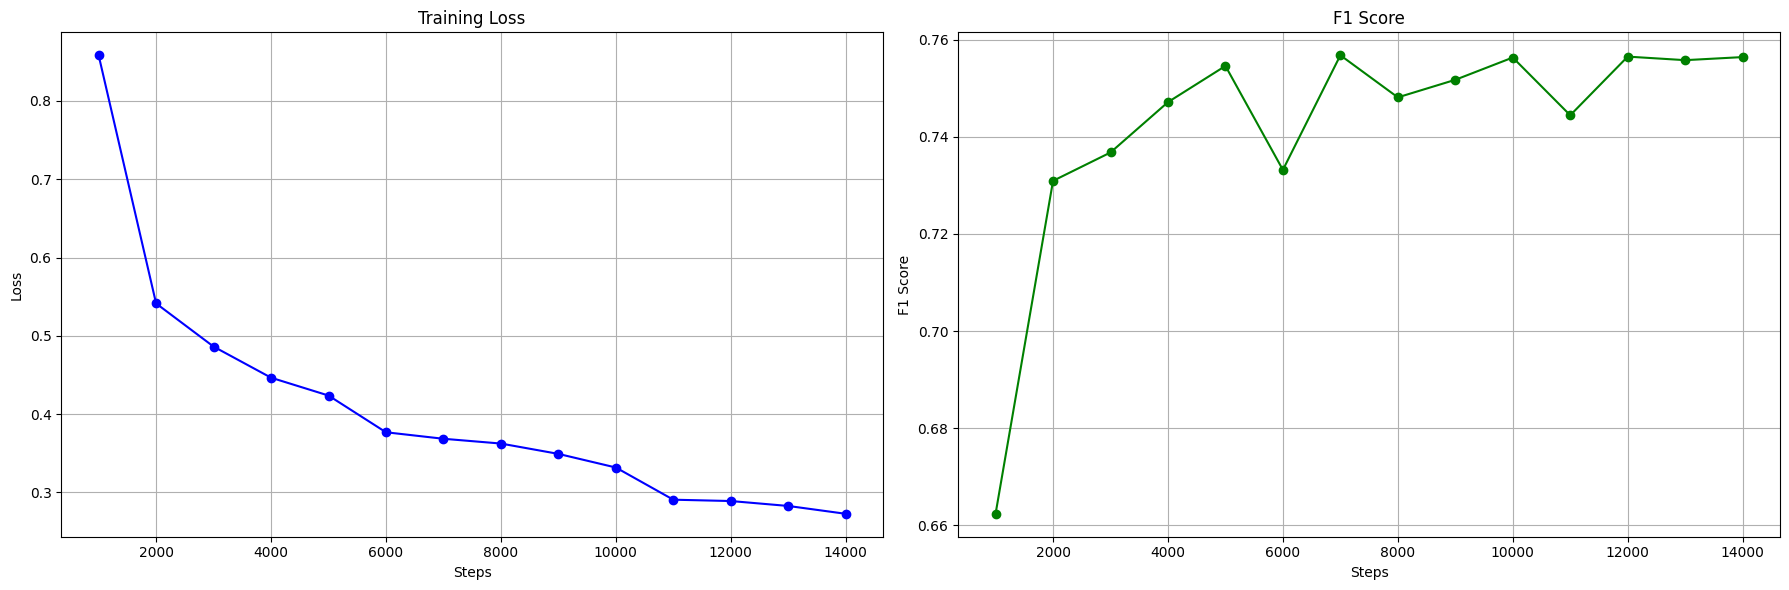

In [ ]:
import matplotlib.pyplot as plt

# Dati
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000]
training_loss = [0.858300, 0.541400, 0.486300, 0.446600, 0.423800, 0.376900, 0.368600, 0.362500, 0.349300, 0.331900, 0.290800, 0.289100, 0.282800, 0.272800]
f1_scores = [0.662319, 0.730956, 0.736804, 0.747182, 0.754644, 0.733216, 0.756845, 0.748165, 0.751785, 0.756377, 0.744475, 0.756565, 0.755835, 0.756469]

# Creazione dei grafici
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 6))

# Grafico della training loss
ax1.plot(steps, training_loss, marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Grafico della F1 score
ax3.plot(steps, f1_scores, marker='o', color='green')
ax3.set_title('F1 Score')
ax3.set_xlabel('Steps')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_1,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.923278272151947,
 'eval_model_preparation_time': 0.0066,
 'eval_accuracy': 0.7433318758198514,
 'eval_f1': 0.7363539173144747,
 'eval_precision': 0.7390790540116516,
 'eval_recall': 0.7433318758198514,
 'eval_runtime': 49.2003,
 'eval_samples_per_second': 46.483,
 'eval_steps_per_second': 5.813}

In [ ]:
# Inizializzare il Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test_ad,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics              # Calcola l'F1 score e altre metriche
)

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 1.2598927021026611,
 'eval_model_preparation_time': 0.0054,
 'eval_accuracy': 0.6201780415430267,
 'eval_f1': 0.622192520058543,
 'eval_precision': 0.632356255106868,
 'eval_recall': 0.6201780415430267,
 'eval_runtime': 7.0345,
 'eval_samples_per_second': 47.907,
 'eval_steps_per_second': 6.113}

# Grafici

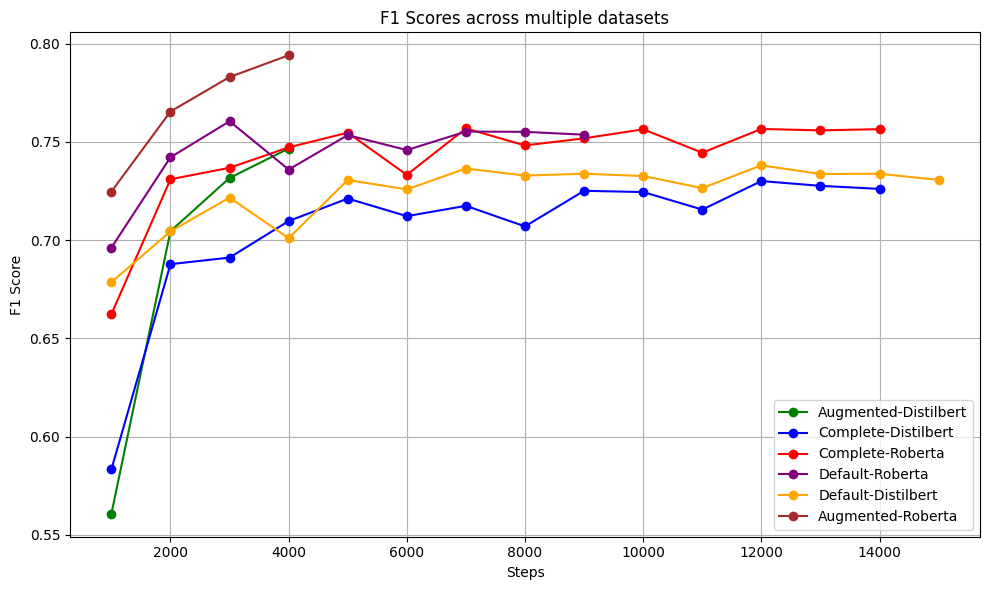

In [ ]:
import matplotlib.pyplot as plt

# Dati F1 Score da più set
steps_1 = [1000, 2000, 3000, 4000]
f1_scores_1 = [0.560737, 0.704554, 0.731635, 0.746586]

steps_2 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000]
f1_scores_2 = [0.583332, 0.687762, 0.691104, 0.709703, 0.721149, 0.712199, 0.717439, 0.706981, 0.725094, 0.724453, 0.715542, 0.730050, 0.727612, 0.726059]

steps_3 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000]
f1_scores_3 = [0.662319, 0.730956, 0.736804, 0.747182, 0.754644, 0.733216, 0.756845, 0.748165, 0.751785, 0.756377, 0.744475, 0.756565, 0.755835, 0.756469]

steps_4 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
f1_scores_4 = [0.696151, 0.742138, 0.760480, 0.735900, 0.753426, 0.745822, 0.755228, 0.755091, 0.753640]

steps_5 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
f1_scores_5 = [0.678574, 0.704420, 0.721617, 0.700986, 0.730578, 0.725803, 0.736433, 0.732833, 0.733793, 0.732598, 0.726471, 0.738064, 0.733607, 0.733776, 0.730611]

steps_6 = [1000, 2000, 3000, 4000]
f1_scores_6 = [ 0.724664, 0.765431, 0.782981, 0.794059]

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Grafico per ciascun set di dati con colori diversi
plt.plot(steps_1, f1_scores_1, marker='o', color='green', label='Augmented-Distilbert')
plt.plot(steps_2, f1_scores_2, marker='o', color='blue', label='Complete-Distilbert')
plt.plot(steps_3, f1_scores_3, marker='o', color='red', label='Complete-Roberta')
plt.plot(steps_4, f1_scores_4, marker='o', color='purple', label='Default-Roberta')
plt.plot(steps_5, f1_scores_5, marker='o', color='orange', label='Default-Distilbert')
plt.plot(steps_6, f1_scores_6, marker='o', color='brown', label='Augmented-Roberta')

# Aggiunta di titolo e etichette
plt.title('F1 Scores across multiple datasets')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.grid(True)

# Aggiunta della legenda per identificare i diversi set
plt.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

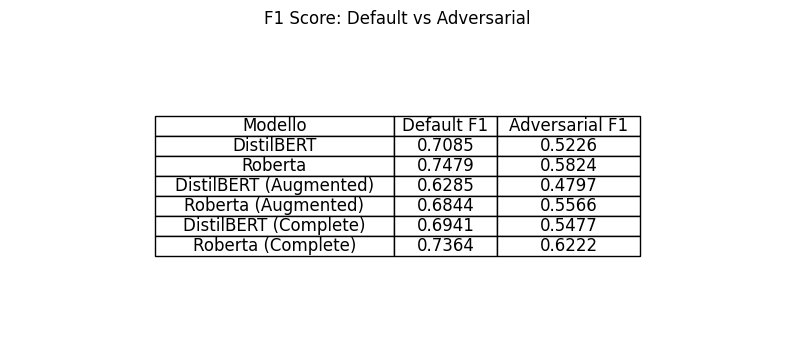

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dati F1 Score
data_f1 = {
    'Modello': ['DistilBERT', 'Roberta', 'DistilBERT (Augmented)', 'Roberta (Augmented)', 'DistilBERT (Complete)', 'Roberta (Complete)'],
    'Default F1': [0.7085, 0.7479, 0.6285, 0.6844, 0.6941, 0.7364],
    'Adversarial F1': [0.5226, 0.5824, 0.4797, 0.5566, 0.5477, 0.6222]
}

# Creazione del DataFrame
df_f1 = pd.DataFrame(data_f1)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_f1.values, colLabels=df_f1.columns, cellLoc='center', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
table.auto_set_column_width([0, 1, 2])

# Imposta lo sfondo della tabella a bianco
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Mostra la tabella
plt.title('F1 Score: Default vs Adversarial')
plt.show()


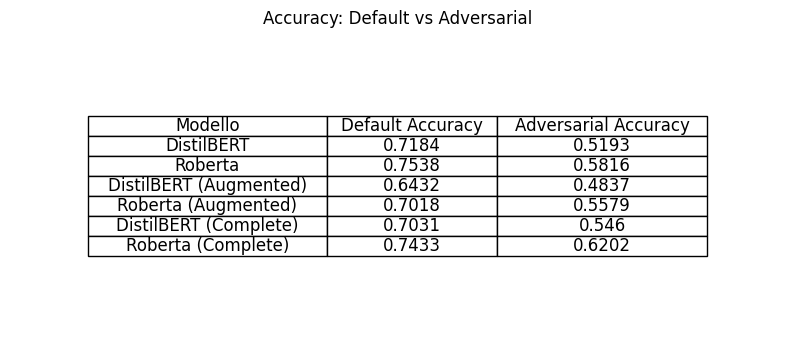

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dati Accuracy
data_accuracy = {
    'Modello': ['DistilBERT', 'Roberta', 'DistilBERT (Augmented)', 'Roberta (Augmented)', 'DistilBERT (Complete)', 'Roberta (Complete)'],
    'Default Accuracy': [0.7184, 0.7538, 0.6432, 0.7018, 0.7031, 0.7433],
    'Adversarial Accuracy': [0.5193, 0.5816, 0.4837, 0.5579, 0.5460, 0.6202]
}

# Creazione del DataFrame
df_accuracy = pd.DataFrame(data_accuracy)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_accuracy.values, colLabels=df_accuracy.columns, cellLoc='center', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
table.auto_set_column_width([0, 1, 2])

# Imposta lo sfondo della tabella a bianco
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Mostra la tabella
plt.title('Accuracy: Default vs Adversarial')
plt.show()

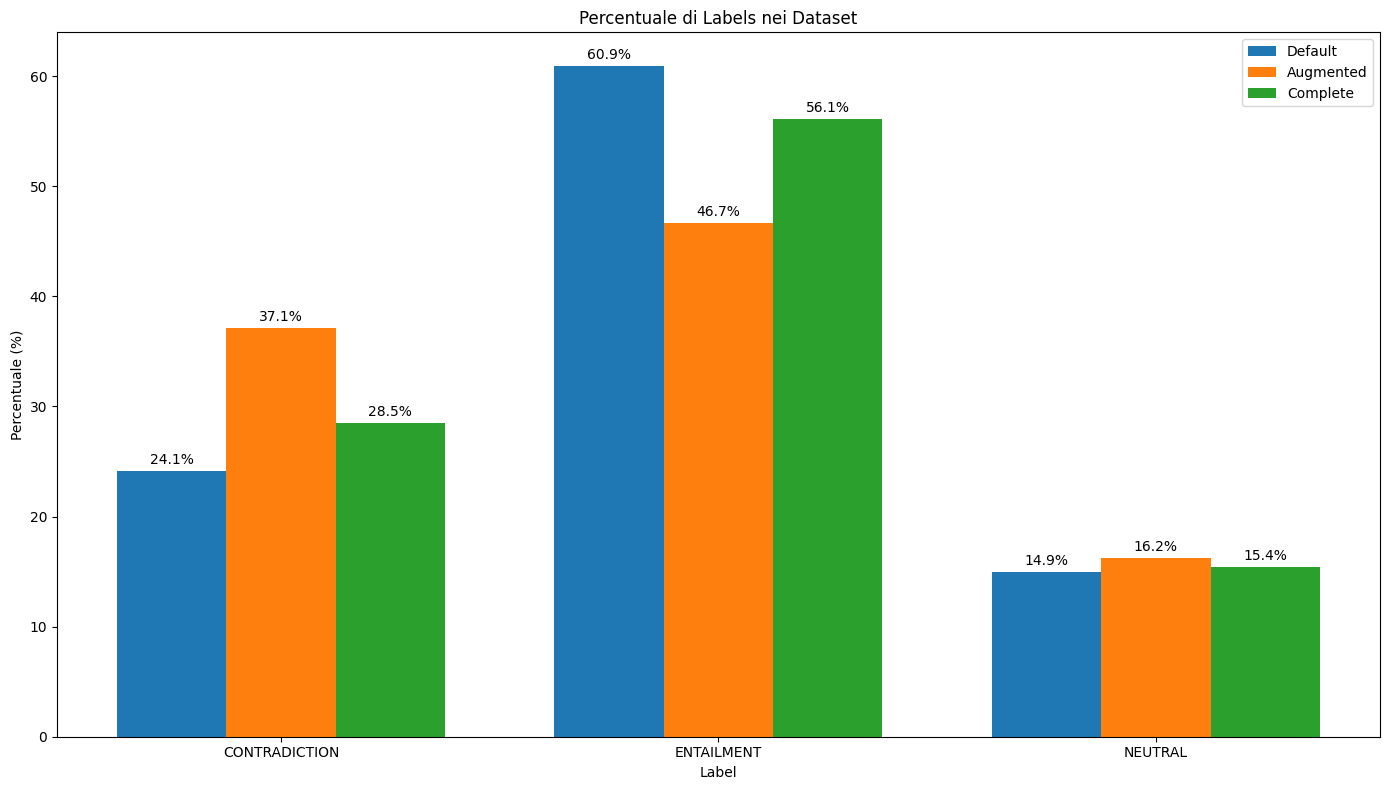

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dataset
ds1 = load_dataset("tommasobonomo/sem_augmented_fever_nli")
ds2 = load_dataset("Masergio/modified_dataset_train")
ds3 = load_dataset("Masergio/complete_dataset")

# Funzione per calcolare le percentuali dei labels
def calculate_label_percentages(dataset):
    labels = dataset['train']['label']
    label_counts = pd.Series(labels).value_counts(normalize=True) * 100
    return label_counts

# Calcola le percentuali dei labels per ciascun dataset
percentages_ds1 = calculate_label_percentages(ds1)
percentages_ds2 = calculate_label_percentages(ds2)
percentages_ds3 = calculate_label_percentages(ds3)

# Creazione di un DataFrame per le percentuali
data_percentages = {
    'Label': sorted(set(percentages_ds1.index) | set(percentages_ds2.index) | set(percentages_ds3.index)),
    'Default': [percentages_ds1.get(label, 0) for label in sorted(set(percentages_ds1.index) | set(percentages_ds2.index) | set(percentages_ds3.index))],
    'Augmented': [percentages_ds2.get(label, 0) for label in sorted(set(percentages_ds1.index) | set(percentages_ds2.index) | set(percentages_ds3.index))],
    'Complete': [percentages_ds3.get(label, 0) for label in sorted(set(percentages_ds1.index) | set(percentages_ds2.index) | set(percentages_ds3.index))]
}

df_percentages = pd.DataFrame(data_percentages)

# Creazione del grafico
fig, ax = plt.subplots(figsize=(14, 8))

# Indici per le barre
bar_width = 0.25
index = range(len(df_percentages))

# Colori per le barre
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Aggiungi le barre per ciascun dataset
bars1 = ax.bar([i - bar_width for i in index], df_percentages['Default'], bar_width, label='Default', color=colors[0])
bars2 = ax.bar(index, df_percentages['Augmented'], bar_width, label='Augmented', color=colors[1])
bars3 = ax.bar([i + bar_width for i in index], df_percentages['Complete'], bar_width, label='Complete', color=colors[2])

# Etichette e titolo
ax.set_xlabel('Label')
ax.set_ylabel('Percentuale (%)')
ax.set_title('Percentuale di Labels nei Dataset')
ax.set_xticks(index)
ax.set_xticklabels(df_percentages['Label'])
ax.legend()

# Aggiungi le etichette di percentuale sopra le barre
def add_percentages(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti verticali di spostamento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_percentages(bars1)
add_percentages(bars2)
add_percentages(bars3)

# Mostra il grafico
plt.tight_layout()
plt.show()

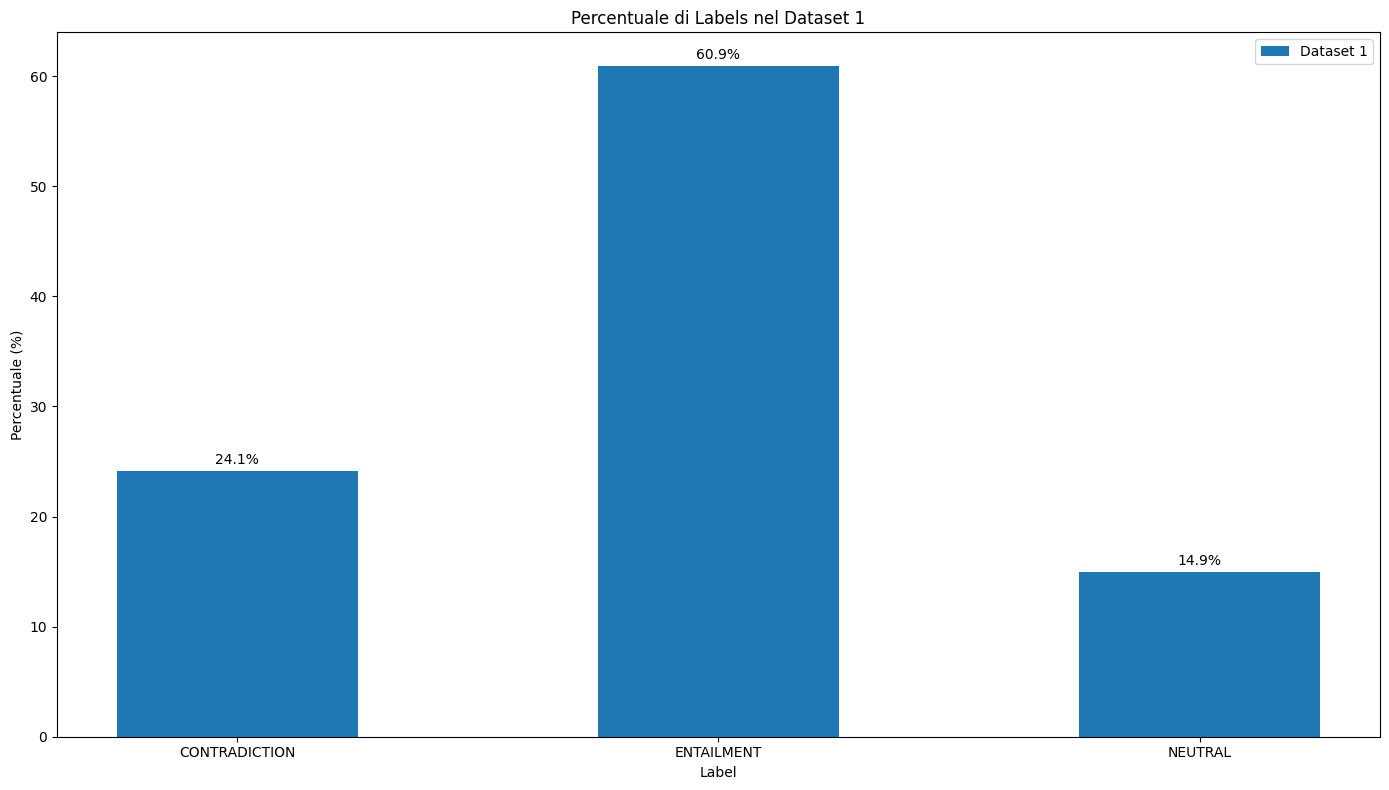

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Carica il dataset
ds1 = load_dataset("tommasobonomo/sem_augmented_fever_nli")

# Funzione per calcolare le percentuali dei labels
def calculate_label_percentages(dataset):
    labels = dataset['train']['label']
    label_counts = pd.Series(labels).value_counts(normalize=True) * 100
    return label_counts

# Calcola le percentuali dei labels per il primo dataset
percentages_ds1 = calculate_label_percentages(ds1)

# Creazione di un DataFrame per le percentuali
labels = sorted(percentages_ds1.index)
data_percentages = {
    'Label': labels,
    'Dataset 1': [percentages_ds1.get(label, 0) for label in labels],
}

df_percentages = pd.DataFrame(data_percentages)

# Creazione del grafico
fig, ax = plt.subplots(figsize=(14, 8))

# Indici per le barre
bar_width = 0.5
index = range(len(df_percentages))

# Colori per le barre
color = '#1f77b4'

# Aggiungi le barre per il dataset
bars = ax.bar(index, df_percentages['Dataset 1'], bar_width, label='Dataset 1', color=color)

# Etichette e titolo
ax.set_xlabel('Label')
ax.set_ylabel('Percentuale (%)')
ax.set_title('Percentuale di Labels nel Dataset 1')
ax.set_xticks(index)
ax.set_xticklabels(df_percentages['Label'])
ax.legend()

# Aggiungi le etichette di percentuale sopra le barre
def add_percentages(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti verticali di spostamento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_percentages(bars)

# Mostra il grafico
plt.tight_layout()
plt.show()

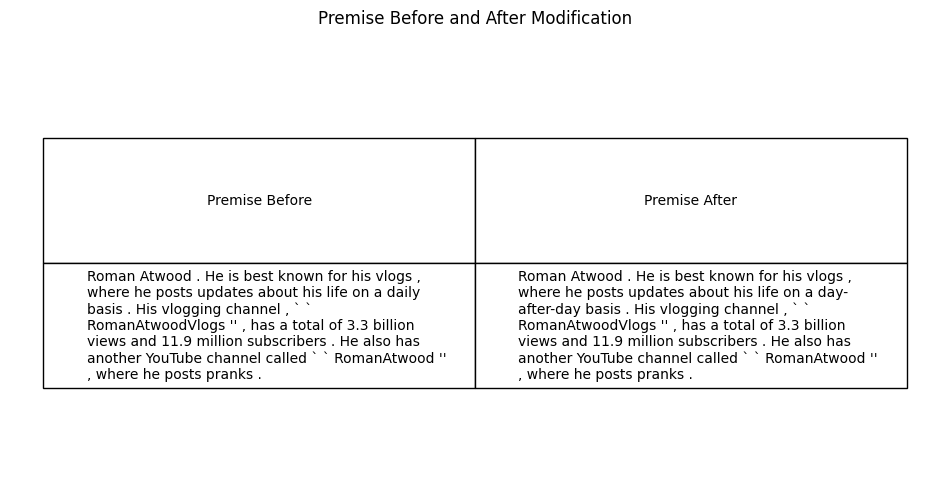

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=50):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle premesse
data_premises = {
    'Premise Before': [
        wrap_text("Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , ` ` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called ` ` RomanAtwood '' , where he posts pranks .")
    ],
    'Premise After': [
        wrap_text("Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a day-after-day basis . His vlogging channel , ` ` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called ` ` RomanAtwood '' , where he posts pranks .")
    ]
}

# Creazione del DataFrame
df_premises = pd.DataFrame(data_premises)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(12, 6))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_premises.values, colLabels=df_premises.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.2, 7.5)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Premise Before and After Modification')
plt.show()


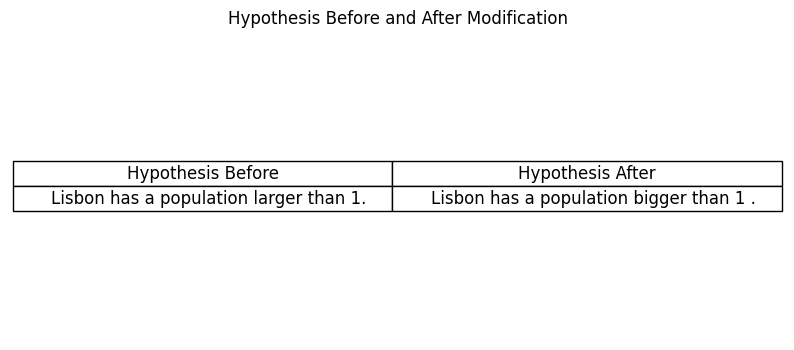

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Lisbon has a population larger than 1.")
    ],
    'Hypothesis After': [
        wrap_text("Lisbon has a population bigger than 1 .")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()


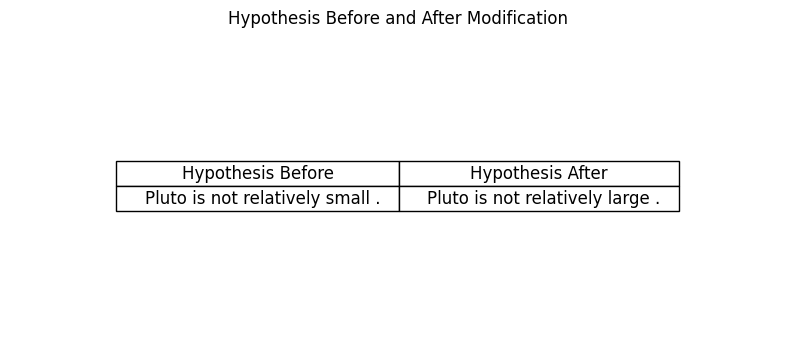

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Pluto is not relatively small .")
    ],
    'Hypothesis After': [
        wrap_text("Pluto is not relatively large .")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()

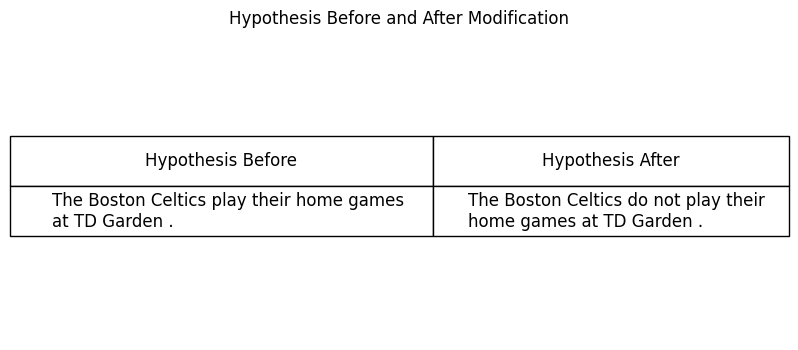

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("The Boston Celtics play their home games at TD Garden .")
    ],
    'Hypothesis After': [
        wrap_text("The Boston Celtics do not play their home games at TD Garden .")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 3.0)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()

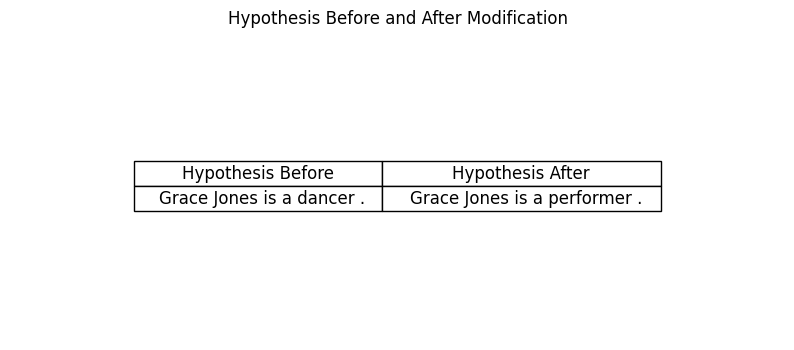

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Grace Jones is a dancer .")
    ],
    'Hypothesis After': [
        wrap_text("Grace Jones is a performer .")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()

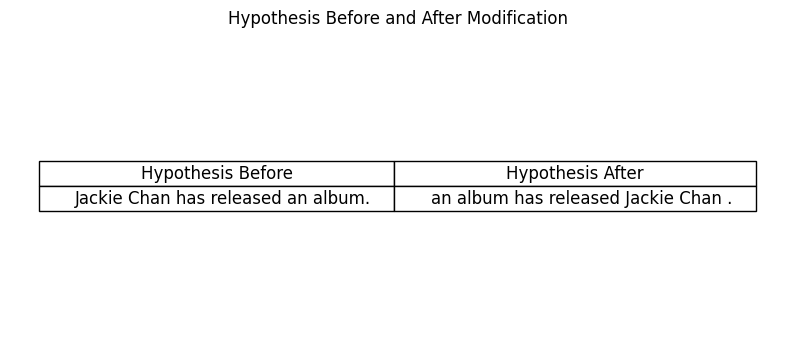

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Jackie Chan has released an album.")
    ],
    'Hypothesis After': [
        wrap_text("an album has released Jackie Chan .")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()

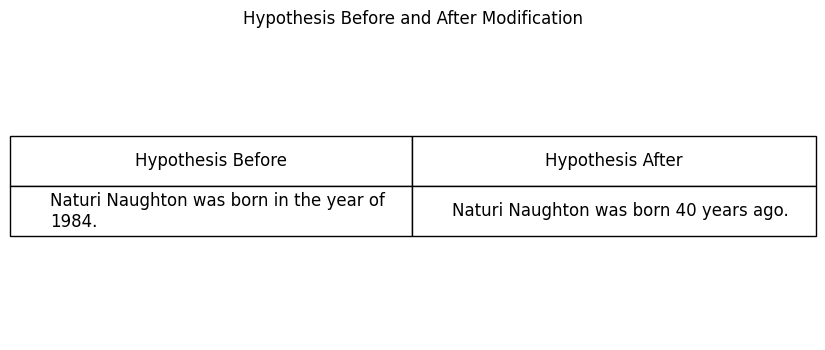

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Naturi Naughton was born in the year of 1984.")
    ],
    'Hypothesis After': [
        wrap_text("Naturi Naughton was born 40 years ago.")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 3)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()

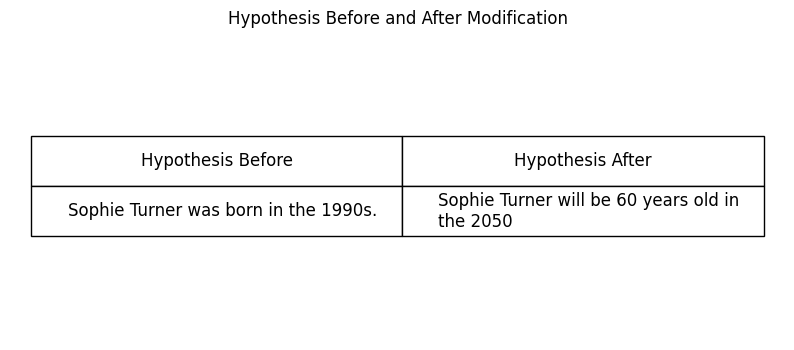

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Funzione per fare il wrapping del testo
def wrap_text(text, width=40):
    """Wraps text to fit within a specified width."""
    return textwrap.fill(text, width=width)

# Dati delle ipotesi
data_hypotheses = {
    'Hypothesis Before': [
        wrap_text("Sophie Turner was born in the 1990s.")
    ],
    'Hypothesis After': [
        wrap_text("Sophie Turner will be 60 years old in the 2050")
    ]
}

# Creazione del DataFrame
df_hypotheses = pd.DataFrame(data_hypotheses)

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 4))

# Nascondi gli assi
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Creazione della tabella
table = ax.table(cellText=df_hypotheses.values, colLabels=df_hypotheses.columns, cellLoc='left', loc='center')

# Personalizzazione della tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 3)  # Aumenta l'altezza delle righe per il testo a capo

# Imposta lo sfondo della tabella a bianco e gestisce i bordi
for key, cell in table._cells.items():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')

# Modifica la larghezza delle colonne
table.auto_set_column_width([0, 1])

# Mostra la tabella
plt.title('Hypothesis Before and After Modification')
plt.show()